## IMPORTS

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, Birch, DBSCAN
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from pyclustertend import hopkins

## DATA LOADING

In [15]:
data = pd.read_csv('../data/cleaned/data_final.csv', )
data = data.drop(columns="url")
data.head()


,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,elevator,garage,storage_room,balcony,new,condition,year,agency,consumption_label,emissions_label,description
0,440000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.000000,2,2,3.0,exterior,True,True,True,True,False,Buen estado,2025.0,ORDUNTE Inmobiliaria,A,A,"GASTOS DE GESTIoN de 1,5 por ciento + IVA a ca..."
1,442000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,67.104025,2,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
2,381000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,44.045770,1,1,4.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
3,575000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,88.240759,3,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
4,306000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,47.888812,1,1,1.0,exterior,True,True,False,False,True,Nuevo,2025.0,Loiola,A,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac..."


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              1229 non-null   float64
 1   zone               1229 non-null   object 
 2   neighborhood       1229 non-null   object 
 3   built_area         1229 non-null   float64
 4   usable_area        1229 non-null   float64
 5   bedrooms           1229 non-null   int64  
 6   bathrooms          1229 non-null   int64  
 7   floor              1229 non-null   float64
 8   exterior           1229 non-null   object 
 9   elevator           1229 non-null   bool   
 10  garage             1229 non-null   bool   
 11  storage_room       1229 non-null   bool   
 12  balcony            1229 non-null   bool   
 13  new                1229 non-null   bool   
 14  condition          1229 non-null   object 
 15  year               1229 non-null   float64
 16  agency             1229 

## FEATURE SELECTION

In [17]:
# ============================================================
# DEFINIR COLUMNAS Y TIPO DE DATOS
# ============================================================

columnascategory = ["zone","neighborhood","exterior","condition","agency","consumption_label","emissions_label"]
data[columnascategory] = data[columnascategory].astype('category')
numerical_cols = ['price', 'built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor', 'year']
data[numerical_cols] = data[numerical_cols].astype('int')
categorical_cols = list(data.select_dtypes(include=['category']).columns)
boolean_cols = list(data.select_dtypes(include=['bool']).columns)




A = data[categorical_cols + numerical_cols + boolean_cols]

# ============================================================
# PREPROCESADO: OneHot + Passthrough
# ============================================================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('bool', 'passthrough', boolean_cols)
    ]
)

A_preprocessed = preprocessor.fit_transform(A)

# Recuperar nombres de columnas tras OneHot
ohe_cols = preprocessor.named_transformers_['cat'] \
        .get_feature_names_out(categorical_cols)

feature_names = numerical_cols + list(ohe_cols) + boolean_cols

# ============================================================
# HACER CLUSTERING (KMeans)
# ============================================================
kmeans = KMeans(n_clusters=5, random_state=123)
clusters = kmeans.fit_predict(A_preprocessed)

# ============================================================
# FEATURE SELECTION POR MUTUAL INFORMATION
# ============================================================
if hasattr(A_preprocessed, "toarray"):
    A_dense = A_preprocessed.toarray()
else:
    A_dense = A_preprocessed

scores = mutual_info_classif(A_dense, clusters, random_state=123)

# Crear tabla ordenada de importancia
ranking = pd.DataFrame({
    "feature": feature_names,
    "importance": scores
}).sort_values(by="importance", ascending=False)

# Separar mejores y peores (umbral: media)
threshold = ranking["importance"].mean()
selected_features = ranking[ranking["importance"] > threshold]
removed_features = ranking[ranking["importance"] <= threshold]

# ============================================================
# RESULTADOS
# ============================================================
print("\n=========================================")
print(" FEATURES MÁS IMPORTANTES")
print("=========================================")
print(selected_features)
#EN RESUMEN LAS FEATURES MAS RELEVANTES SON LAS NUMERICAS

print("\n=========================================")
print(" FEATURES MENOS RELEVANTES")
print("=========================================")
print(removed_features)



 FEATURES MÁS IMPORTANTES
                           feature  importance
0                            price    1.273963
1                       built_area    0.527204
2                      usable_area    0.489703
4                        bathrooms    0.365650
3                         bedrooms    0.219441
..                             ...         ...
366            consumption_label_A    0.018044
10                zone_casco-viejo    0.018002
116          agency_Carolina Marin    0.017761
341     agency_carlos buerba arena    0.017761
188  agency_INMOBILIARIA BASAGOITI    0.017627

[94 rows x 2 columns]

 FEATURES MENOS RELEVANTES
                                     feature  importance
185                            agency_INMOAS    0.017410
308  agency_Quorum Promociones de Obra Nueva    0.017220
148                    agency_Erreka Garrido    0.016931
60           neighborhood_Solokoetxe, Bilbao    0.016911
184                    agency_INFINITY HOMES    0.016837
..              

## KMEANS

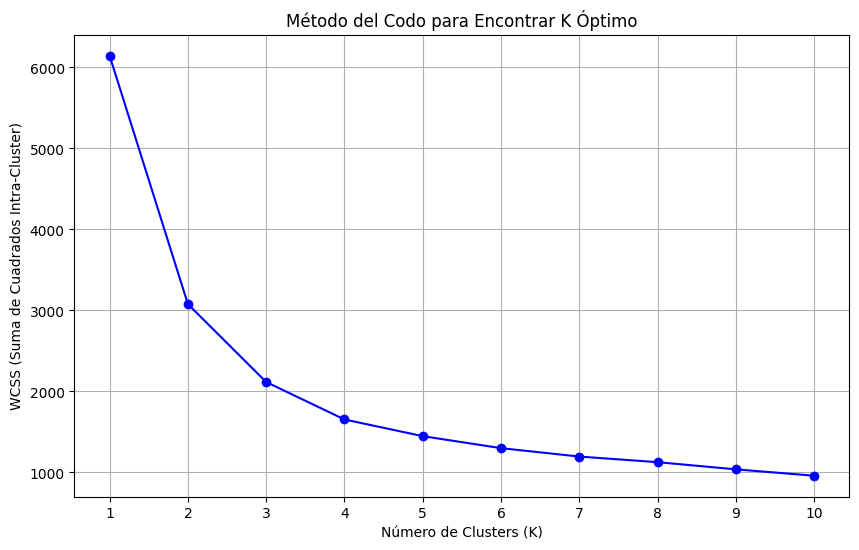

K=2: Silhouette Score = 0.5712
K=3: Silhouette Score = 0.4116
K=4: Silhouette Score = 0.4213
K=5: Silhouette Score = 0.3750
K=6: Silhouette Score = 0.3626
K=7: Silhouette Score = 0.3618
K=5: Silhouette Score = 0.3750
K=6: Silhouette Score = 0.3626
K=7: Silhouette Score = 0.3618
K=8: Silhouette Score = 0.3606
K=9: Silhouette Score = 0.3423
K=10: Silhouette Score = 0.3485
K óptimo según Silhouette Score: 2
--- Resultado del Análisis de Silueta ---
K=8: Silhouette Score = 0.3606
K=9: Silhouette Score = 0.3423
K=10: Silhouette Score = 0.3485
K óptimo según Silhouette Score: 2
--- Resultado del Análisis de Silueta ---
Silhouette Score = 0.41155510072631113
Hopkins Statistic = 0.032558407707782996
Silhouette Score = 0.41155510072631113
Hopkins Statistic = 0.032558407707782996


In [18]:
features = ['price', 'built_area', 'bedrooms', 'bathrooms', 'usable_area']
X = data[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

#Visualización del Método del Codo (guarda el plot)
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='blue')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Cluster)')
plt.xticks(K_range)
plt.grid(True)
plt.show()  

# Definir rango de K para análisis de silueta


silhouette_scores = {}
K_range = range(2, 11) 


for k in K_range:
    # Entrenar K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Calcular el Silhouette Score
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores[k] = score
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Encontrar el K con la puntuación más alta
K_optimal_silhouette = max(silhouette_scores, key=silhouette_scores.get)
print(f"K óptimo según Silhouette Score: {K_optimal_silhouette}")
best_score = silhouette_scores[K_optimal_silhouette]

print("--- Resultado del Análisis de Silueta ---")

K_OPTIMAL = 3 # El k mas optimo segun el codo es 3 y segun la silueta es 2, se elige 3 para mantener consistencia con el codo


kmeans_final = KMeans(n_clusters=K_OPTIMAL, init='k-means++', random_state=42, n_init=10)
y_kmeans = kmeans_final.fit_predict(X_scaled) 
silhouette_avg = silhouette_score(X_scaled, y_kmeans) # Calculate the overall Silhouette Score

print(f"Silhouette Score = {silhouette_avg}") 

# --- Hopkins Statistic Calculation ---
data_k_means_evaluation = X_scaled
n_samples = data_k_means_evaluation.shape[0]

if n_samples > 2:
    hopkins_score = hopkins(data_k_means_evaluation, n_samples)
    print(f"Hopkins Statistic = {hopkins_score}")
else:
    print("Cannot calculate Hopkins Statistic: Not enough samples in the data (n_samples <= 2).")



## GAUSSIAN MIXTURE

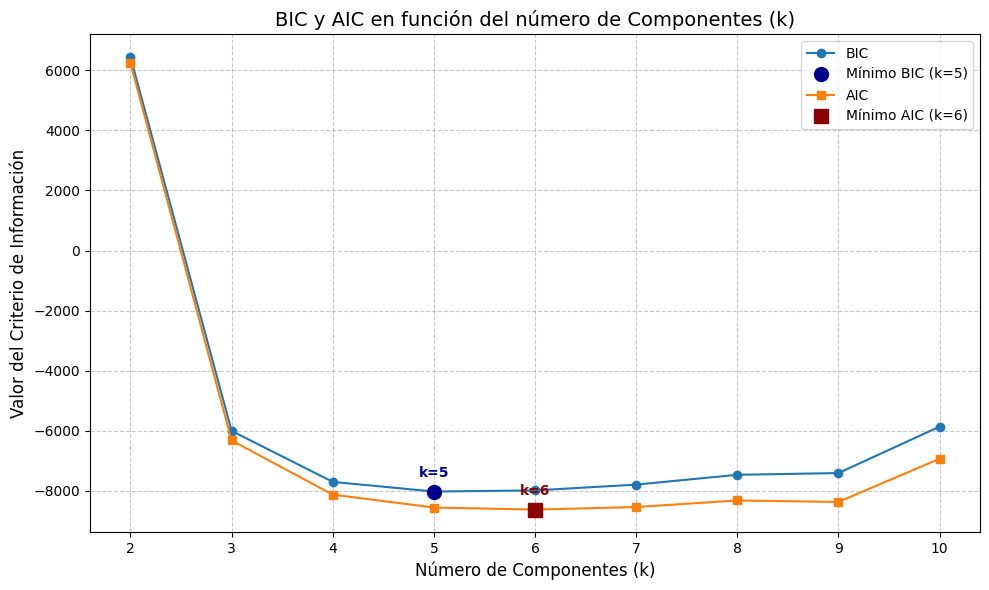

--- Resultados de BIC y AIC para GMM ---
BIC; [np.float64(6443.400526132358), np.float64(-6005.038210201648), np.float64(-7701.42310018824), np.float64(-8023.232800782977), np.float64(-7984.586880750274), np.float64(-7792.68989906903), np.float64(-7465.560790575003), np.float64(-7407.876710164432), np.float64(-5863.553803993588)]
AIC; [np.float64(6233.728325640151), np.float64(-6322.103488994742), np.float64(-8125.881457282221), np.float64(-8555.084236177845), np.float64(-8623.831394446028), np.float64(-8539.327491065671), np.float64(-8319.59146087253), np.float64(-8369.300458762846), np.float64(-6932.3706308928895)]


In [19]:



# Usamos el Criterio de Información Bayesiano (BIC) y el Criterio de Información de Akaike (AIC)
n_components = np.arange(2, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components]

# Calculamos BIC y AIC
bic = [m.bic(X_scaled) for m in models]
aic = [m.aic(X_scaled) for m in models]







# Encontrar los puntos mínimos
min_bic_index = np.argmin(bic)
min_aic_index = np.argmin(aic)
optimal_k_bic = n_components[min_bic_index]
optimal_k_aic = n_components[min_aic_index]

# --- Generación del Gráfico ---
plt.figure(figsize=(10, 6))

# Graficar BIC
plt.plot(n_components, bic, label='BIC', marker='o', color='tab:blue')
# Marcar el punto mínimo de BIC
plt.plot(optimal_k_bic, bic[min_bic_index], 'o', color='darkblue', markersize=10, label=f'Mínimo BIC (k={optimal_k_bic})')
plt.text(optimal_k_bic, bic[min_bic_index] + 500, f'k={optimal_k_bic}', ha='center', color='darkblue', fontweight='bold')

# Graficar AIC
plt.plot(n_components, aic, label='AIC', marker='s', color='tab:orange')
# Marcar el punto mínimo de AIC
plt.plot(optimal_k_aic, aic[min_aic_index], 's', color='darkred', markersize=10, label=f'Mínimo AIC (k={optimal_k_aic})')
plt.text(optimal_k_aic, aic[min_aic_index] + 500, f'k={optimal_k_aic}', ha='center', color='darkred', fontweight='bold')

# Títulos y Etiquetas
plt.title('BIC y AIC en función del número de Componentes (k)', fontsize=14)
plt.xlabel('Número de Componentes (k)', fontsize=12)
plt.ylabel('Valor del Criterio de Información', fontsize=12)
plt.xticks(n_components) # Asegura que solo se muestren los k probados
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama

# Mostrar el gráfico
plt.show()





print("--- Resultados de BIC y AIC para GMM ---")
print("BIC;", bic)
print("AIC;", aic)


In [20]:
lowest_bic = np.inf
best_gmm = None
optimal_k = 0
optimal_cv_type = ''
cv_types = ['spherical', 'tied', 'diag', 'full'] 

# usando las features mejoradas con un k diferente a 4 lo supere.

print("--- Búsqueda en Malla: k y Tipo de Covarianza ---")
for cv_type in cv_types:
    for n_comp in n_components: 
        # Si el modelo no converge, puede lanzar un error. Usaremos try/except por robustez.
        try:
            gmm_model = GaussianMixture(n_components=n_comp, covariance_type=cv_type, random_state=42)
            gmm_model.fit(X_scaled)
            current_bic = gmm_model.bic(X_scaled)
            # Comprobar si es el mejor modelo BIC hasta ahora
            if current_bic < lowest_bic:
                lowest_bic = current_bic
                optimal_k = n_comp
                optimal_cv_type = cv_type
                best_gmm = gmm_model
        except Exception as e:
            # Ignorar modelos que no convergen
            print(f"Advertencia: El modelo k={n_comp}, cv='{cv_type}' falló.")
            continue

print(f"\nMejor Combinación BIC Encontrada: k={optimal_k}, Covarianza='{optimal_cv_type}'")
print(f"BIC Mínimo: {lowest_bic:.2f}")

# --- Reaplicar GMM con el MEJOR Modelo BIC y Evaluar Silueta ---
if best_gmm is not None:
    cluster_gmm_final = best_gmm.predict(X_scaled)
    silhouette_avg_final = silhouette_score(X_scaled, cluster_gmm_final)
    
    print(f"\n--- Resultados del Modelo FINAL (k={optimal_k}, {optimal_cv_type}) ---")
    print(f"Índice de Silueta Promedio FINAL: {silhouette_avg_final:.4f}")
else:
    print(" No se pudo encontrar un modelo GMM convergente. Revisa la limpieza de datos.")
    



--- Búsqueda en Malla: k y Tipo de Covarianza ---

Mejor Combinación BIC Encontrada: k=5, Covarianza='full'
BIC Mínimo: -8023.23

--- Resultados del Modelo FINAL (k=5, full) ---
Índice de Silueta Promedio FINAL: 0.3715

Mejor Combinación BIC Encontrada: k=5, Covarianza='full'
BIC Mínimo: -8023.23

--- Resultados del Modelo FINAL (k=5, full) ---
Índice de Silueta Promedio FINAL: 0.3715


## BIRCH MODE

In [21]:


# --- 1. Configuración del Grid Search ---
# Threshold: El radio del sub-clúster. 
#   - Bajo (0.1): Muchos micro-clústeres finos.
#   - Alto (0.75): Pocos macro-clústeres gruesos.
threshold_values = [0.1, 0.2,0.05,0.075]

# Branching Factor: Cuántos sub-nodos puede tener cada rama. 
#   - 50 es estándar, probamos 20 y 100 para ver si afecta la estructura del árbol.
branching_values = [20, 50, 100]

# n_clusters: El paso final de refinamiento.
n_clusters_values = [ 2,3, 4, 5,6,7,8,9,10]

results = []
best_score = -1
best_params = {}
best_labels = None

print("Iniciando búsqueda de hiperparámetros para BIRCH...")

count = 0
total_iters = len(threshold_values) * len(branching_values) * len(n_clusters_values)

for t in threshold_values:
    for b in branching_values:
        for k in n_clusters_values:
            try:
                # Entrenar BIRCH
                # n_clusters=k fuerza un paso final de aglomeración para llegar a k grupos
                birch = Birch(threshold=t, branching_factor=b, n_clusters=k)
                labels = birch.fit_predict(X_scaled)
                
                # Validar que no haya generado un solo cluster por error
                unique_labels = np.unique(labels)
                if len(unique_labels) < 2:
                    continue
                
                # Calcular métricas
                sil = silhouette_score(X_scaled, labels)
                ch = calinski_harabasz_score(X_scaled, labels)
                
                # Analizar distribución (para detectar clusters gigantes)
                counts = pd.Series(labels).value_counts()
                max_ratio = counts.max() / len(labels) # % del cluster más grande
                
                results.append({
                    'threshold': t,
                    'branching': b,
                    'n_clusters': k,
                    'silhouette': sil,
                    'calinski': ch,
                    'max_cluster_ratio': max_ratio
                })
                
                # Guardar el mejor (Maximizando Silueta)
                if sil > best_score:
                    best_score = sil
                    best_params = {'threshold': t, 'branching': b, 'n_clusters': k}
                    best_labels = labels
                    print(f"  ->  Nuevo mejor: k={k}, thr={t}, Silueta={sil:.4f} (Max Clúster: {max_ratio:.1%})")
                    
            except Exception as e:
                # A veces BIRCH falla si el threshold es muy bajo para la cantidad de datos
                continue

# --- 2. Resultados de la Búsqueda ---

print("\n" + "="*40)
print(f"🏆 MEJOR CONFIGURACIÓN BIRCH")
print("="*40)
print(f"Threshold (Radio): {best_params['threshold']}")
print(f"Branching Factor: {best_params['branching']}")
print(f"Número de Clústeres (k): {best_params['n_clusters']}")
print(f"Silueta: {best_score:.4f}")

# --- 3. Análisis de Distribución de Puntos (Lo que pediste) ---

if best_labels is not None:
    print("\nAnálisis Detallado de los Clústeres Ganadores:")
    
    # Crear DataFrame resumen
    df_dist = pd.Series(best_labels).value_counts().reset_index()
    df_dist.columns = ['Cluster_Label', 'Cantidad_Puntos']
    
    # Calcular porcentaje
    total_pts = len(X_scaled)
    df_dist['Porcentaje'] = (df_dist['Cantidad_Puntos'] / total_pts) * 100
    df_dist = df_dist.sort_values(by='Cluster_Label')
    
    print(df_dist.to_string(index=False))
    
    # Alerta de balance
    max_pct = df_dist['Porcentaje'].max()
    if max_pct > 80:
        print(f"\n OJO: El clúster dominante tiene el {max_pct:.1f}% de los datos.")
        print("Si k=2, esto podría ser normal (fondo vs anomalía), pero revísalo.")
    elif max_pct < 60 and best_params['n_clusters'] == 2:
        print("\n Balance excelente: Los grupos están bien repartidos.")

# --- 4. Top 5 Configuraciones ---
print("\nTop 5 Configuraciones probadas:")
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='silhouette', ascending=False).head(5))

Iniciando búsqueda de hiperparámetros para BIRCH...
  ->  Nuevo mejor: k=2, thr=0.1, Silueta=0.6083 (Max Clúster: 89.5%)
  ->  Nuevo mejor: k=2, thr=0.1, Silueta=0.6309 (Max Clúster: 92.1%)
  ->  Nuevo mejor: k=2, thr=0.1, Silueta=0.6309 (Max Clúster: 92.1%)
  ->  Nuevo mejor: k=2, thr=0.2, Silueta=0.6360 (Max Clúster: 92.6%)
  ->  Nuevo mejor: k=2, thr=0.2, Silueta=0.6360 (Max Clúster: 92.6%)

🏆 MEJOR CONFIGURACIÓN BIRCH
Threshold (Radio): 0.2
Branching Factor: 20
Número de Clústeres (k): 2
Silueta: 0.6360

Análisis Detallado de los Clústeres Ganadores:
 Cluster_Label  Cantidad_Puntos  Porcentaje
             0             1138   92.595606
             1               91    7.404394

 OJO: El clúster dominante tiene el 92.6% de los datos.
Si k=2, esto podría ser normal (fondo vs anomalía), pero revísalo.

Top 5 Configuraciones probadas:
    threshold  branching  n_clusters  silhouette     calinski  \
27       0.20         20           2    0.636007   920.500015   
45       0.20       

## DB SCAN (Y CLUSTERS FINAL)

In [ ]:
# --- Configuración de la Búsqueda ---

# 1. AJUSTE DE RANGOS:
# Si antes tenías un clúster gigante, necesitamos 'eps' más pequeños.
# Probamos pasos más finos en la zona baja (0.05 a 0.8).
eps_values = np.arange(0.05, 0.8, 0.05) 

# 2. AUMENTO DE MIN_SAMPLES:
# Aumentar esto rompe los puentes débiles entre clústeres.
min_samples_values = [5,10, 15, 20, 25, 30] 

best_score = -1
best_params = {'eps': None, 'min_samples': None}
best_labels = None
results = []

print(" Iniciando búsqueda optimizada para evitar 'Mega-Clústeres'...")

for eps in eps_values:
    for ms in min_samples_values:
        
        # Ejecutar DBSCAN
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        
        # Estadísticas básicas
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        total_samples = len(labels)
        noise_ratio = n_noise / total_samples
        
        # --- NUEVO FILTRO: TAMAÑO DEL CLÚSTER MÁS GRANDE ---
        # Calculamos qué porcentaje de datos tiene el clúster más grande
        if n_clusters > 0:
            counts = pd.Series(labels).value_counts()
            if -1 in counts: counts = counts.drop(-1) # Ignorar ruido para este cálculo
            largest_cluster_ratio = counts.max() / total_samples
        else:
            largest_cluster_ratio = 1.0 # Si todo es ruido o un solo grupo

        # --- CRITERIOS DE FILTRADO MEJORADOS ---
        # 1. Rango de clústeres (2 a 50)
        # 2. Ruido controlado (menos del 50%, DBSCAN suele generar ruido, es normal)
        # 3. CRÍTICO: El clúster más grande NO puede tener más del 60% de los datos
        
        if (2 <= n_clusters <= 50) and (noise_ratio < 0.50) and (largest_cluster_ratio < 0.60):
            
            # Calcular Silueta (solo en core points)
            core_mask = labels != -1
            if np.sum(core_mask) > len(unique_labels): 
                sil_score = silhouette_score(X_scaled[core_mask], labels[core_mask])
                
                results.append({
                    'eps': eps, 
                    'min_samples': ms, 
                    'n_clusters': n_clusters, 
                    'noise_ratio': noise_ratio, 
                    'largest_cluster_ratio': largest_cluster_ratio,
                    'silhouette': sil_score
                })
                
                # Guardar el mejor
                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {'eps': eps, 'min_samples': ms}
                    best_labels = labels
                    print(f"  ->  Candidato: eps={eps:.2f}, ms={ms} | Clústers={n_clusters} | Max_Clúster={largest_cluster_ratio:.2%} | Silueta={sil_score:.4f}")

# --- Resultados ---
if best_params['eps'] is not None:
    print("\n" + "="*40)
    print(f"MEJOR CONFIGURACIÓN EQUILIBRADA")
    print("="*40)
    print(f"Epsilon: {best_params['eps']:.2f}")
    print(f"Min Samples: {best_params['min_samples']}")
    print(f"Silueta: {best_score:.4f}")
    
    # Mostrar distribución de tamaños
    final_counts = pd.Series(best_labels).value_counts().sort_index()
    print("\nDistribución por clúster (Etiqueta: Cantidad):")
    print(final_counts.to_string())
    
    # Tabla resumen top 5
    df_res = pd.DataFrame(results)
    print("\nTop 5 configuraciones:")
    print(df_res.sort_values(by='silhouette', ascending=False).head(5)[['eps', 'min_samples', 'n_clusters', 'largest_cluster_ratio', 'silhouette']])

else:
    print("\nAún no se encuentra una configuración válida.")
    print("Prueba: 1) Aumentar ligeramente el límite de ruido permitido, o 2) Revisar si las variables necesitan una transformación (Log/PowerTransform) antes de escalar.")

import pandas as pd

# Asumiendo que tus etiquetas están en 'best_labels' o 'labels'
conteos = pd.Series(best_labels).value_counts().sort_index()

print("Distribución de puntos por Clúster:")
print(conteos)
    
                                                                                 

 Iniciando búsqueda optimizada para evitar 'Mega-Clústeres'...
  ->  Candidato: eps=0.15, ms=5 | Clústers=19 | Max_Clúster=14.24% | Silueta=0.3500
  ->  Candidato: eps=0.20, ms=10 | Clústers=11 | Max_Clúster=16.19% | Silueta=0.4330
  ->  Candidato: eps=0.25, ms=15 | Clústers=7 | Max_Clúster=17.33% | Silueta=0.4568
  ->  Candidato: eps=0.25, ms=20 | Clústers=5 | Max_Clúster=16.11% | Silueta=0.4966
  ->  Candidato: eps=0.30, ms=30 | Clústers=5 | Max_Clúster=15.87% | Silueta=0.5021
  ->  Candidato: eps=0.25, ms=15 | Clústers=7 | Max_Clúster=17.33% | Silueta=0.4568
  ->  Candidato: eps=0.25, ms=20 | Clústers=5 | Max_Clúster=16.11% | Silueta=0.4966
  ->  Candidato: eps=0.30, ms=30 | Clústers=5 | Max_Clúster=15.87% | Silueta=0.5021

MEJOR CONFIGURACIÓN EQUILIBRADA
Epsilon: 0.30
Min Samples: 30
Silueta: 0.5021

Distribución por clúster (Etiqueta: Cantidad):
-1    579
 0     89
 1     46
 2    195
 3    142
 4    178

Top 5 configuraciones:
     eps  min_samples  n_clusters  largest_cluster_ra

LIDIANDO CON OUTLIERS

In [23]:
# 1. Preparar datos para KNN
mask_core = best_labels != -1
X_core = X_scaled[mask_core]   # Las islas de color (entrenamiento)
y_core = best_labels[mask_core]
X_noise = X_scaled[~mask_core] # El océano gris (a predecir)

# -----------------------------------------------------------------------------
# NUEVO BLOQUE: CÁLCULO DEL K ÓPTIMO (Sustituye la elección manual)
# -----------------------------------------------------------------------------

def calcular_k_optimo_explicado(X_train, X_query, k_min=3, k_max=15):
    """
    Calcula el K óptimo basándose en cuándo la distancia a los vecinos
    empieza a crecer demasiado (criterio del codo).
    """
    print(f"--- ANÁLISIS DE VECINOS (KNN) PARA REASIGNACIÓN ---")
    print(f"Objetivo: Encontrar cuántos vecinos consultar para clasificar los {len(X_query)} outliers.")
    
    # Usamos NearestNeighbors solo para medir distancias (sin clasificar aún)
    nbrs = NearestNeighbors(n_neighbors=k_max, algorithm='auto').fit(X_train)
    
    mean_distances = []
    best_k = k_min
    prev_slope = 0
    elbow_found = False
    
    print(f"|  K  | Distancia Media | Aceleración (Cambio) | Decisión")
    print("|-----|-----------------|----------------------|---------")

    for k in range(k_min, k_max + 1):
        # Obtenemos distancias a los k vecinos
        distances, _ = nbrs.kneighbors(X_query, n_neighbors=k)
        avg_dist = np.mean(distances)
        mean_distances.append(avg_dist)
        
        # Análisis de la pendiente (cuánto crece la distancia al añadir un vecino más)
        slope = 0
        decision = ""
        
        if k > k_min:
            slope = avg_dist - mean_distances[-2]
            
            # CRITERIO: Si la pendiente actual es mucho mayor que la anterior, 
            # significa que estamos saltando a vecinos lejanos (otro cluster o ruido lejano).
            # Usamos un factor de 1.5 como umbral de "salto brusco".
            if not elbow_found and slope > prev_slope * 1.5 and prev_slope > 0:
                decision = "CODO: Distancia se dispara. Paramos aquí."
                best_k = k - 1 # Nos quedamos con el anterior al salto
                elbow_found = True
            elif not elbow_found:
                decision = "Estable. Buscando más consenso..."
                best_k = k # Si es estable, preferimos más vecinos (más democrático)
        else:
            decision = "Punto inicial"
            
        prev_slope = slope if slope > 0 else 1e-6
        
        # Imprimimos el análisis fila por fila
        print(f"| {k:^3} | {avg_dist:.4f}          | {slope:.4f}               | {decision}")
        
        

    print(f"\n>>> CONCLUSIÓN: Se utilizará k={best_k}")
    print(f"Razón: Es el punto de equilibrio donde tenemos la mayor cantidad de información")
    print(f"local antes de que los vecinos empiecen a estar demasiado lejos (riesgo de contaminación).\n")
    
    return best_k

if len(X_noise) > 0:
    # Forzamos que busque al menos 5 vecinos para que la votación sea sólida
    k_optimo = calcular_k_optimo_explicado(X_core, X_noise, k_min=5, k_max=15)
else:
    k_optimo = 5  # Valor por defecto si no hay ruido
# -----------------------------------------------------------------------------
# TU CÓDIGO EXISTENTE MODIFICADO (PASOS 2 y 3)
# -----------------------------------------------------------------------------

# 2. Entrenar KNN usando el k_optimo calculado automáticamente
print(f"Entrenando KNeighborsClassifier con n_neighbors={k_optimo}...")
knn = KNeighborsClassifier(n_neighbors=k_optimo)
knn.fit(X_core, y_core)

# 3. Predecir y Crear Etiquetas Finales
if len(X_noise) > 0:
    noise_pred = knn.predict(X_noise)
    final_labels = best_labels.copy()
    final_labels[~mask_core] = noise_pred
    print("Asignación completada exitosamente.")
else:
    final_labels = best_labels.copy()


--- ANÁLISIS DE VECINOS (KNN) PARA REASIGNACIÓN ---
Objetivo: Encontrar cuántos vecinos consultar para clasificar los 579 outliers.
|  K  | Distancia Media | Aceleración (Cambio) | Decisión
|-----|-----------------|----------------------|---------
|  5  | 1.7518          | 0.0000               | Punto inicial
|  6  | 1.7598          | 0.0080               | CODO: Distancia se dispara. Paramos aquí.
|  7  | 1.7668          | 0.0070               | 
|  8  | 1.7737          | 0.0069               | 
|  9  | 1.7801          | 0.0064               | 
| 10  | 1.7861          | 0.0060               | 
| 11  | 1.7918          | 0.0057               | 
| 12  | 1.7973          | 0.0055               | 
| 13  | 1.8025          | 0.0052               | 
| 14  | 1.8076          | 0.0051               | 
| 15  | 1.8126          | 0.0049               | 

>>> CONCLUSIÓN: Se utilizará k=5
Razón: Es el punto de equilibrio donde tenemos la mayor cantidad de información
local antes de que los vecinos emp

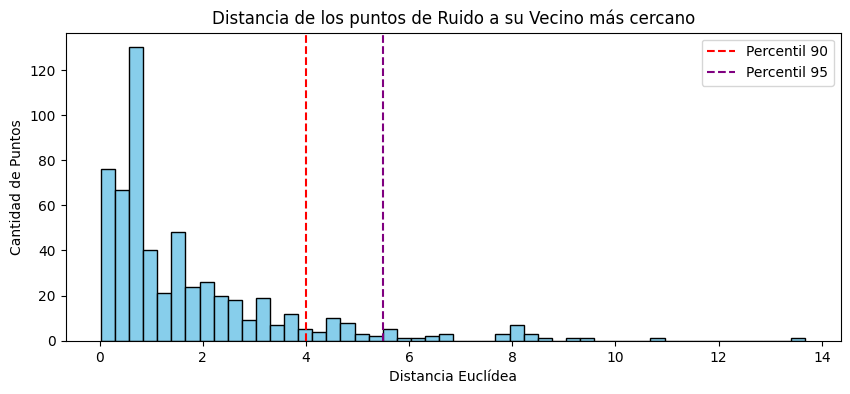

📊 Estadísticas de distancia:
count    579.000000
mean       1.709666
std        1.867541
min        0.024454
25%        0.585417
50%        0.921069
75%        2.245701
max       13.683108
dtype: float64
Aplicando corte en distancia: 5.50

Recuento Final de Clústeres (con Outliers reales aislados):
-1     29
 0    110
 1     92
 2    615
 3    192
 4    191
Name: count, dtype: int64

Recuento Final de Clústeres (con Outliers reales aislados):
-1     29
 0    110
 1     92
 2    615
 3    192
 4    191
Name: count, dtype: int64


In [24]:


# 1. Recuperamos distancias y vecinos
# distance: qué tan lejos está el vecino
# indices: quién es el vecino
distances, indices = knn.kneighbors(X_noise)

# Nos quedamos con la distancia al vecino más cercano (columna 0)
dist_to_neighbor = distances[:, 0]

# --- PASO CRÍTICO: VER EL HISTOGRAMA PARA DECIDIR EL CORTE ---
plt.figure(figsize=(10, 4))
plt.hist(dist_to_neighbor, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(dist_to_neighbor, 90), color='r', linestyle='--', label='Percentil 90')
plt.axvline(np.percentile(dist_to_neighbor, 95), color='purple', linestyle='--', label='Percentil 95')
plt.title('Distancia de los puntos de Ruido a su Vecino más cercano')
plt.xlabel('Distancia Euclídea')
plt.ylabel('Cantidad de Puntos')
plt.legend()
plt.show()

print("📊 Estadísticas de distancia:")
print(pd.Series(dist_to_neighbor).describe())

# --- 2. APLICAR EL FILTRO (DERECHO DE ADMISIÓN) ---
# Define aquí tu límite basado en la gráfica anterior. 
# Por lo que veo en tu PCA, los puntos lejanos están MUY lejos.
# Un valor seguro suele ser el percentil 95 (descartar el 5% más lejano).
limite_distancia = np.percentile(dist_to_neighbor, 95) 

print(f"Aplicando corte en distancia: {limite_distancia:.2f}")

# Predecir de nuevo
noise_pred_filtered = knn.predict(X_noise)

# Donde la distancia sea mayor al límite, forzamos de nuevo a -1 (Ruido Real)
noise_pred_filtered[dist_to_neighbor > limite_distancia] = -1

# Actualizar etiquetas finales
final_labels_refined = best_labels.copy()
final_labels_refined[~mask_core] = noise_pred_filtered



# Conteo final
print("\nRecuento Final de Clústeres (con Outliers reales aislados):")
print(pd.Series(final_labels_refined).value_counts().sort_index())

## RESUMEN FINAL

TABLA MAESTRA: Perfil Numérico (Medias)
               Count       price  built_area  usable_area  bedrooms  bathrooms  floor     year
Cluster_Final                                                                                 
-1                29  1451102.28      377.03       344.83      7.72       3.41   3.38  1938.38
 0               110   273375.41       56.47        49.42      1.00       1.00   3.73  1960.06
 1                92   415207.98       88.83        74.58      1.98       2.00   3.41  1997.51
 2               615   611053.76      140.12       125.53      3.67       2.27   3.83  1965.16
 3               192   269890.10       85.07        77.05      3.22       1.00   3.46  1951.79
 4               191   252653.43       68.73        62.36      1.99       1.00   3.68  1947.61


🎨 DISTRIBUCIÓN DE CATEGÓRICAS Y BOOLEANAS POR CLÚSTER (True/False)

🔹 Variable: ELEVATOR
elevator       False  True 
Cluster_Final              
-1               6.9   93.1
 0               0.0  100

C:\Users\gonzalo.iglesias\AppData\Local\Temp\ipykernel_23832\2787396439.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Final', y='price', data=df_analysis, palette='tab10')


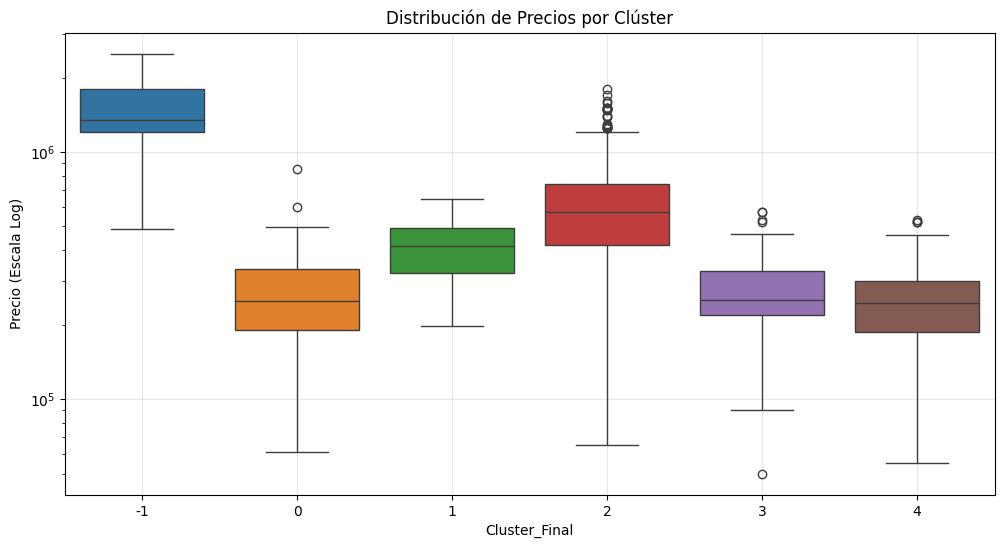

In [ ]:


# 1. Preparación
df_analysis = data.copy()
df_analysis['Cluster_Final'] = final_labels_refined

# --- PARTE A: Variables ÚNICAMENTE Numéricas (Medias) ---
print("TABLA MAESTRA: Perfil Numérico (Medias)")
print("=========================================")

# 💡 MODIFICACIÓN CLAVE: Creamos una lista solo con las variables numéricas
# que NO son booleanas para el cálculo de la media.
# Esto es esencialmente 'numerical_cols' menos 'boolean_cols'.
# Si 'numerical_cols' solo contenía numéricas continuas/discretas y las booleanas, 
# la diferencia es simple:
numerical_only = [col for col in numerical_cols if col not in boolean_cols]

# 1. Agrupamos las numéricas (Mean + Count)
summary_num = df_analysis.groupby('Cluster_Final')[numerical_only].mean()

# 2. Añadimos el conteo
conteo = df_analysis['Cluster_Final'].value_counts().sort_index()
summary_num.insert(0, 'Count', conteo) 

# Redondeamos y mostramos la tabla de SÓLO NUMÉRICAS
print(summary_num.round(2).to_string())


# --- PARTE B: Variables Categóricas y BOOLEANAS (Distribución %) ---
print("\n\n🎨 DISTRIBUCIÓN DE CATEGÓRICAS Y BOOLEANAS POR CLÚSTER (True/False)")
print("="*60)

# Unimos booleanas y categóricas para el análisis de frecuencia (pd.crosstab)
all_cols_to_crosstab = boolean_cols + categorical_cols

# Iteramos por cada columna
for col in all_cols_to_crosstab:
    print(f"\n🔹 Variable: {col.upper()}")
    
    # Tabla cruzada: Filas=Cluster, Columnas=Categorías (o True/False para booleanas)
    cross_tab = pd.crosstab(
        df_analysis['Cluster_Final'], 
        df_analysis[col], 
        normalize='index' # Normaliza por fila (clúster)
    ) * 100
    
    print(cross_tab.round(1).to_string())
    print("-" * 60)

# --- PARTE C: Visualización de Precios ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Final', y='price', data=df_analysis, palette='tab10')
plt.title('Distribución de Precios por Clúster')
plt.yscale('log') 
plt.ylabel('Precio (Escala Log)')
plt.grid(True, alpha=0.3)
plt.show()